In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

np.random.seed(40)

In [2]:
# Data Load
df_train = pd.read_csv('train.csv')
df_train = df_train.iloc[:,1:]
df_train.columns = ['hour', 'temp', 'precip',
       'windspeed', 'humidity', 'visibility',
       'ozone', 'pm10', 'pm2_5', 'count']
df_X = df_train[df_train.columns.drop('count')]
df_y = df_train['count'].values

X_train, X_val, y_train, y_val = train_test_split(df_X, df_y, test_size=0.3, random_state=0)

In [3]:
# Visualize Pipeline
from sklearn import set_config

set_config(display="diagram")

In [4]:
# Data Preprocessing
numeric_features = list(df_X.columns.drop(['precip','hour']))
numeric_transformer = Pipeline(
    steps=[("imputer",SimpleImputer(strategy='median')),("scaler",StandardScaler())]
)
hour_feature = ['hour']
hour_transformer = Pipeline(
    steps=[("imputer",SimpleImputer(strategy='most_frequent')),('scaler',StandardScaler(with_std=False))]
 ) # hour은 standardscaler에서 표준편차로 나누는 것은 제외함.
hour_transformer_oh = OneHotEncoder(handle_unknown='ignore',sparse=False) # hour을 onehotencoding으로 처리

categorical_features = ['precip']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ('hour', hour_transformer, hour_feature),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [5]:
# Tree Regressor
from sklearn.tree import DecisionTreeRegressor
tree_reg = Pipeline(
    steps=[("preprocessor",preprocessor),
    ("tree",DecisionTreeRegressor(criterion="squared_error"))]
)
tree_reg.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'windspeed',
                                                   'humidity', 'visibility',
                                                   'ozone', 'pm10', 'pm2_5']),
                                                 ('hour',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler(with_std=False))]),
                                                  ['hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['precip'])])),
                ('tree', DecisionTreeRegressor())])

In [6]:
# Tree Info and Validation RMSE
tree_res = tree_reg.named_steps['tree']
tree_res.get_depth() # 20
tree_res.get_n_leaves() # 967
tree_pred = tree_reg.predict(X_val)
np.sqrt(mean_squared_error(y_val, tree_pred)).round(3) # 50.643


50.643

In [7]:
# Check whether Overfitted with Cross-Validation
from tqdm import * # Progress-bar
from sklearn.model_selection import GridSearchCV
params = {'max_features':("sqrt","log2","auto"), "max_depth" : list(range(2, 41, 2))}

# GridSearch Algorithm
N_comb = len(params['max_features']) * len(params['max_depth'])
with tqdm(total=N_comb) as pbar:
    df = []
    for feat in params['max_features']:
        scores = []
        for d in params['max_depth']:
            reg_i = Pipeline(
                steps=[('preprocessor',preprocessor),('tree',DecisionTreeRegressor(max_features=feat,max_depth=d))]
            )
            reg_i.fit(X_train,y_train)
            pred_i = reg_i.predict(X_val)
            score_i = np.sqrt(mean_squared_error(y_val, pred_i)).round(3)
            scores.append(score_i)
            pbar.update()
        df.append(scores)
res = pd.DataFrame(df, index=params['max_features'], columns=params['max_depth']).T

100%|██████████| 60/60 [00:00<00:00, 83.85it/s]


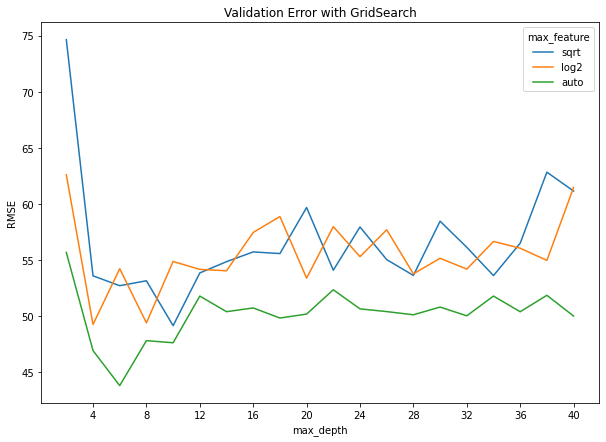

In [8]:
# Plot the result of GridSearch
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(res.index, res['sqrt'], label = 'sqrt')
plt.plot(res.index, res['log2'], label = 'log2')
plt.plot(res.index, res['auto'], label = 'auto')
plt.legend(title = "max_feature", loc = 'upper right')
plt.xticks(range(4,44,4))
ax.set(xlabel="max_depth", ylabel="RMSE", title="Validation Error with GridSearch")
plt.savefig("plots/GridSearch_Tree.png", facecolor = 'white', transparent = False)

100%|██████████| 60/60 [00:00<00:00, 81.18it/s]


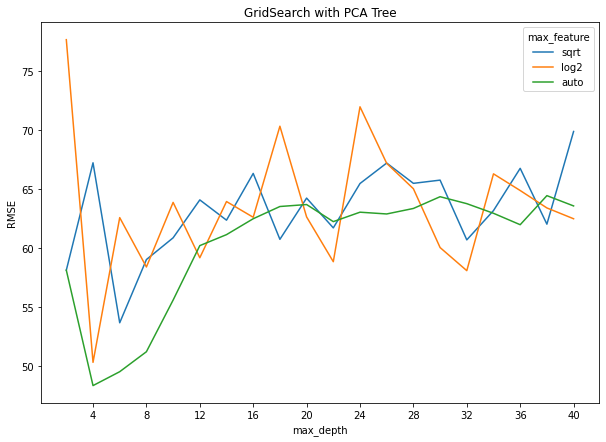

In [9]:
# GridSearch with PCA Tree
from sklearn.decomposition import PCA

params = {'max_features':("sqrt","log2","auto"), "max_depth" : list(range(2, 41, 2))}
N_comb = len(params['max_features']) * len(params['max_depth'])
with tqdm(total=N_comb) as pbar:
    df = []
    for feat in params['max_features']:
        scores = []
        for d in params['max_depth']:
            reg_i = Pipeline(
                steps=[('preprocessor',preprocessor),('pca',PCA(n_components=3)),('tree',DecisionTreeRegressor(max_features=feat,max_depth=d))]
            )
            reg_i.fit(X_train,y_train)
            pred_i = reg_i.predict(X_val)
            score_i = np.sqrt(mean_squared_error(y_val, pred_i)).round(3)
            scores.append(score_i)
            pbar.update()
        df.append(scores)
res = pd.DataFrame(df, index=params['max_features'], columns=params['max_depth']).T

fig, ax = plt.subplots(figsize=(10,7))
plt.plot(res.index, res['sqrt'], label = 'sqrt')
plt.plot(res.index, res['log2'], label = 'log2')
plt.plot(res.index, res['auto'], label = 'auto')
plt.legend(title = "max_feature", loc = 'upper right')
plt.xticks(range(4,44,4))
ax.set(xlabel="max_depth", ylabel="RMSE", title="GridSearch with PCA Tree")
plt.savefig("plots/GridSearch_TreewithPCA.png", facecolor = 'white', transparent = False)

In [10]:
# Three Models : For each max_feature, the argmin max_depth
idx_1 = res.index[np.argmin(res['auto'])]
idx_2 = res.index[np.argmin(res['log2'])]
idx_3 = res.index[np.argmin(res['sqrt'])]


tree_pca_1 = Pipeline(
    steps=[('preprocessor',preprocessor),
        ('pca', PCA(n_components=3)),
        ('tree',DecisionTreeRegressor(max_features='auto',max_depth=idx_1))]
)
tree_pca_2 = Pipeline(
    steps=[('preprocessor',preprocessor),
        ('pca', PCA(n_components=3)),
        ('tree',DecisionTreeRegressor(max_features='log2',max_depth=idx_2))]
)
tree_pca_3 = Pipeline(
    steps=[('preprocessor',preprocessor),
        ('pca', PCA(n_components=3)),
        ('tree',DecisionTreeRegressor(max_features='sqrt',max_depth=idx_3))]
)
tree_pca_1.fit(X_train, y_train)
tree_pca_2.fit(X_train, y_train)
tree_pca_3.fit(X_train, y_train)

pca = tree_pca_1[0:2] # Pipeline until PCA
xs_1, ys_1 = zip(*sorted(zip(pca.transform(X_val)[:,0],tree_pca_1.predict(X_val))))
xs_2, ys_2 = zip(*sorted(zip(pca.transform(X_val)[:,0],tree_pca_2.predict(X_val))))
xs_3, ys_3 = zip(*sorted(zip(pca.transform(X_val)[:,0],tree_pca_3.predict(X_val))))


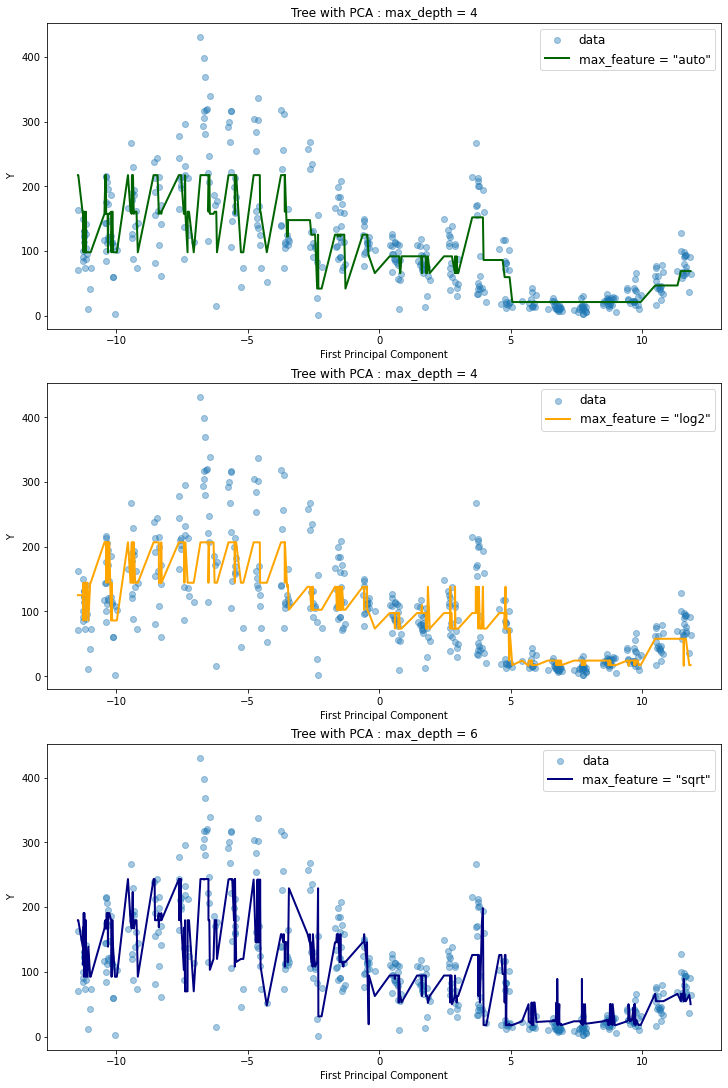

In [11]:
# Compare three Local_Minimum RMSE spot
# Projeted on the first Principal Component

# Plot
fig, axes = plt.subplots(3,1,figsize=(10,15), constrained_layout=True)
axes[0].scatter(pca.transform(X_val)[:,0], y_val, alpha=0.4, label='data')
axes[0].plot(xs_1, ys_1, label = 'max_feature = "auto"', color = "darkgreen", linewidth = 2)
axes[0].legend(fontsize = 12, loc = 'upper right')
axes[0].set(xlabel = "First Principal Component", ylabel="Y",title=f"Tree with PCA : max_depth = {idx_1}")

axes[1].scatter(pca.transform(X_val)[:,0], y_val, alpha=0.4, label='data')
axes[1].plot(xs_2, ys_2, label = 'max_feature = "log2"', color = "orange", linewidth = 2)
axes[1].legend(fontsize = 12, loc = 'upper right')
axes[1].set(xlabel = "First Principal Component", ylabel="Y",title=f"Tree with PCA : max_depth = {idx_2}")

axes[2].scatter(pca.transform(X_val)[:,0], y_val, alpha=0.4, label='data')
axes[2].plot(xs_3, ys_3, label = 'max_feature = "sqrt"', color = "navy", linewidth = 2)
axes[2].legend(fontsize = 12, loc = 'upper right')
axes[2].set(xlabel = "First Principal Component", ylabel="Y",title=f"Tree with PCA : max_depth = {idx_3}")


plt.savefig("plots/tree_pca.png", transparent=False, facecolor='white')

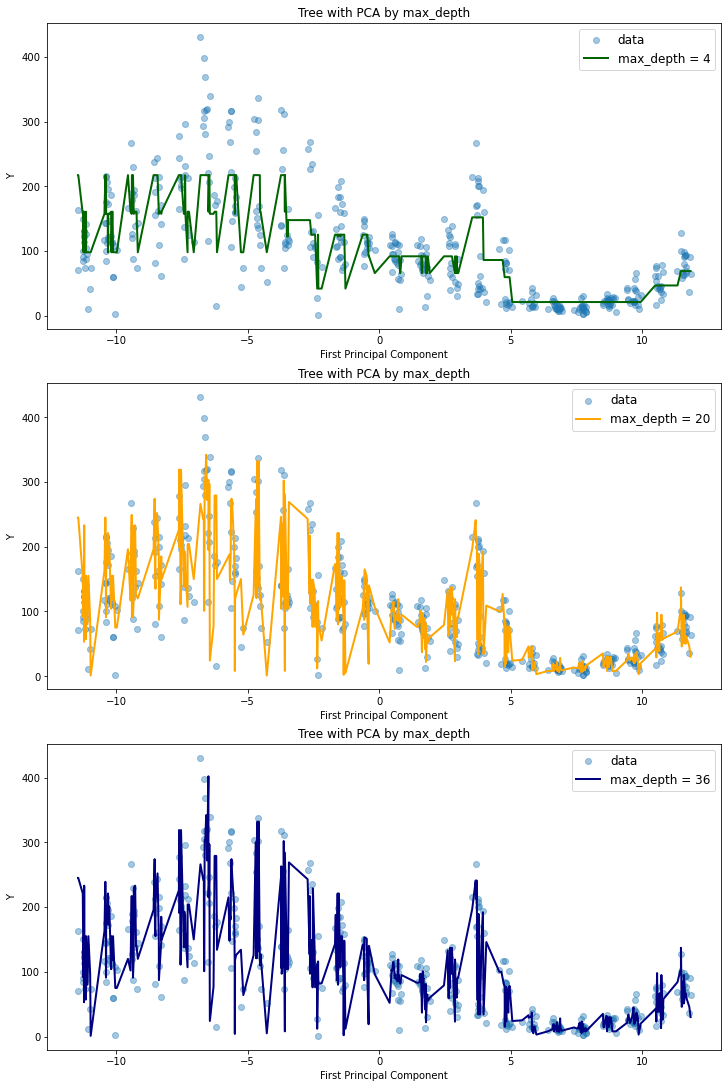

In [12]:
# Same Feature with Different Depth

tree_pca_4 = Pipeline(
    steps=[('preprocessor',preprocessor),
        ('pca', PCA(n_components=3)),
        ('tree',DecisionTreeRegressor(max_features='auto',max_depth=4))]
)
tree_pca_5 = Pipeline(
    steps=[('preprocessor',preprocessor),
        ('pca', PCA(n_components=3)),
        ('tree',DecisionTreeRegressor(max_features='auto',max_depth=20))]
)
tree_pca_6 = Pipeline(
    steps=[('preprocessor',preprocessor),
        ('pca', PCA(n_components=3)),
        ('tree',DecisionTreeRegressor(max_features='auto',max_depth=36))]
)
tree_pca_4.fit(X_train, y_train)
tree_pca_5.fit(X_train, y_train)
tree_pca_6.fit(X_train, y_train)

pca = tree_pca_4[0:2] # Pipeline until PCA
xs_4, ys_4 = zip(*sorted(zip(pca.transform(X_val)[:,0],tree_pca_4.predict(X_val))))
xs_5, ys_5 = zip(*sorted(zip(pca.transform(X_val)[:,0],tree_pca_5.predict(X_val))))
xs_6, ys_6 = zip(*sorted(zip(pca.transform(X_val)[:,0],tree_pca_6.predict(X_val))))

fig, axes = plt.subplots(3,1,figsize=(10,15), constrained_layout=True)
axes[0].scatter(pca.transform(X_val)[:,0], y_val, alpha=0.4, label='data')
axes[0].plot(xs_4, ys_4, label = 'max_depth = 4', color = "darkgreen", linewidth = 2)
axes[0].legend(fontsize = 12, loc = 'upper right')
axes[0].set(xlabel = "First Principal Component", ylabel="Y",title=f"Tree with PCA by max_depth")

axes[1].scatter(pca.transform(X_val)[:,0], y_val, alpha=0.4, label='data')
axes[1].plot(xs_5, ys_5, label = 'max_depth = 20', color = "orange", linewidth = 2)
axes[1].legend(fontsize = 12, loc = 'upper right')
axes[1].set(xlabel = "First Principal Component", ylabel="Y",title=f"Tree with PCA by max_depth")

axes[2].scatter(pca.transform(X_val)[:,0], y_val, alpha=0.4, label='data')
axes[2].plot(xs_6, ys_6, label = 'max_depth = 36', color = "navy", linewidth = 2)
axes[2].legend(fontsize = 12, loc = 'upper right')
axes[2].set(xlabel = "First Principal Component", ylabel="Y",title=f"Tree with PCA by max_depth")


plt.savefig("plots/tree_pca_by_depth.png", transparent=False, facecolor='white')

In [13]:
# GBDT with GridsearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# RMSE def for Gridsearch Scoring
def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return(np.sqrt(mse))
rmse_score = make_scorer(rmse, greater_is_better=False)
# Pipeline Model
tree_gbm = Pipeline([
("preprocessor",preprocessor),("gbm",GradientBoostingRegressor(loss='squared_error',max_features='auto'))
])

In [14]:
# Gridsearch
param_grid = {
    'n_estimators' : 10 * np.logspace(base=2, start=0, stop=5, num=6),
    'max_depth' : np.linspace(4,32,8)
}
search = GridSearchCV(
    tree_gbm, param_grid, verbose=10, n_jobs=2, scoring=rmse_score
)
search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
